Found 2960 images belonging to 2 classes.
Found 2752 images belonging to 2 classes.
Train on 2960 samples, validate on 2752 samples
Epoch 1/50
2960/2960 [==============================] - 8s 3ms/step - loss: 0.7258 - acc: 0.5976 - val_loss: 0.6284 - val_acc: 0.6584
Epoch 2/50
2960/2960 [==============================] - 10818s 4s/step - loss: 0.6404 - acc: 0.6426 - val_loss: 0.6195 - val_acc: 0.6581
Epoch 3/50
2960/2960 [==============================] - 6s 2ms/step - loss: 0.6221 - acc: 0.6510 - val_loss: 0.6036 - val_acc: 0.6708
Epoch 4/50
2960/2960 [==============================] - 14020s 5s/step - loss: 0.6159 - acc: 0.6662 - val_loss: 0.6016 - val_acc: 0.6777
Epoch 5/50
2960/2960 [==============================] - 8s 3ms/step - loss: 0.6031 - acc: 0.6797 - val_loss: 0.6005 - val_acc: 0.6748
Epoch 6/50
2960/2960 [==============================] - -5s -1661us/step - loss: 0.5930 - acc: 0.6858 - val_loss: 0.6058 - val_acc: 0.6893
Epoch 7/50
2960/2960 [==============================]

/Users/kg/.virtualenvs/deeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:188: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`


Found 2960 images belonging to 2 classes.
Found 2752 images belonging to 2 classes.
Epoch 1/50
185/185 [==============================] - 3158s 17s/step - loss: 0.7025 - acc: 0.5861 - val_loss: 0.6330 - val_acc: 0.6628
Epoch 2/50
185/185 [==============================] - 3440s 19s/step - loss: 0.6388 - acc: 0.6351 - val_loss: 0.6166 - val_acc: 0.7024
Epoch 3/50
185/185 [==============================] - 1442s 8s/step - loss: 0.6065 - acc: 0.6740 - val_loss: 0.5668 - val_acc: 0.7238
Epoch 4/50
185/185 [==============================] - 1404s 8s/step - loss: 0.6052 - acc: 0.6818 - val_loss: 0.5830 - val_acc: 0.7093
Epoch 5/50
185/185 [==============================] - 1412s 8s/step - loss: 0.5794 - acc: 0.6926 - val_loss: 0.5655 - val_acc: 0.7322
Epoch 6/50
185/185 [==============================] - 1495s 8s/step - loss: 0.5767 - acc: 0.7091 - val_loss: 0.5599 - val_acc: 0.7307
Epoch 7/50
185/185 [==============================] - 1552s 8s/step - loss: 0.5740 - acc: 0.7020 - val_loss: 0

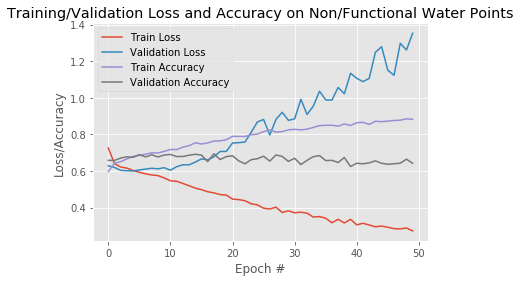

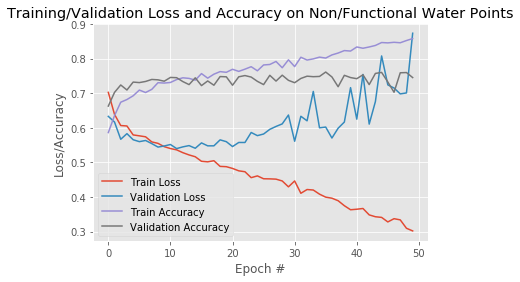

In [88]:
import numpy as np
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import applications, backend as K, optimizers

K.set_image_dim_ordering('tf')

# dimensions of our images.
img_width, img_height = 100, 100

first_try_model_path = 'first_try.h5'
fine_tuned_model_weights_path = 'finetuned_model.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples_func = 1072
nb_train_samples_nonfunc = 1888
nb_train_samples = nb_train_samples_func + nb_train_samples_nonfunc
nb_validation_samples_func = 955
nb_validation_samples_nonfunc = 1797
nb_validation_samples = nb_validation_samples_func + nb_validation_samples_nonfunc
epochs = 50
batch_size = 16

def plot_history(path, history):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), history["loss"], label="Train Loss")
    plt.plot(np.arange(0, epochs), history["val_loss"], label="Validation Loss")
    plt.plot(np.arange(0, epochs), history["acc"], label="Train Accuracy")
    plt.plot(np.arange(0, epochs), history["val_acc"], label="Validation Accuracy")
    plt.title("Training/Validation Loss and Accuracy on Non/Functional Water Points")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")
    plt.savefig(path)

def save(path, model, history):
    plot_history(path + '_performance.png', history)
    model.save(path + '_model.h5')
    model.save_weights(path)
    
def create_model():
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

def build_model():
    model = create_model()

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

    save(first_try_model_path, model, history.history)

def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)

def create_top_model(input_shape):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_shape))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    return top_model

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = np.array(
        [0] * nb_train_samples_nonfunc + [1] * nb_train_samples_func)

    model = create_top_model(train_data.shape[1:])

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * nb_validation_samples_nonfunc + [1] * nb_validation_samples_func)

    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    save(top_model_weights_path, model, history.history)

def fine_tune():
    # build the VGG16 network
    model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(img_height, img_width, 3))
    print('Model loaded.')
    
    top_model = create_top_model(model.output_shape[1:])
    
    # note that it is necessary to start with a fully-trained
    # classifier, including the top classifier,
    # in order to successfully do fine-tuning
    top_model.load_weights(top_model_weights_path)

    # add the model on top of the convolutional base
    model = Model(input=model.input, output=top_model(model.output))
    
    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:15]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    # fine-tune the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
    
    save(fine_tuned_model_weights_path, model, history.history)

### START
# from https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
def get_activations(model,
                    model_inputs, 
                    print_activations=False,
                    print_shape_only=False, 
                    layer_name=None,
                    max_layer=None):
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    model_layers = model.layers
    
    if max_layer and not layer_name:
        max_layers = max_layers[0:max_layer]

    outputs = [layer.output for layer in model_layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    
    if print_activations:
        print('----- activations -----')

    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_activations:
            if print_shape_only:
                print(layer_activations.shape)
            else:
                print(layer_activations)

    return activations


def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()
### END

def plot_trained_model(weights_path,
                       data_dir=validation_data_dir,
                       num_images=1,
                       classes=['func'],
                       save_model_plot=False):
    model.load(weights_path + '_model.h5')

    datagen = ImageDataGenerator(rescale=1. / 255)

    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        classes=classes,
        class_mode='binary')

    for i in xrange(0, num_images):
        activations = get_activations(model, data_generator[i][0], max_layer=-1)
        display_activations(activations)

    if save_model_plot:
        plot_model(model, to_file=weights_path + '.png', show_shapes=True)

def predict(weights_path,
            classes=['func'],
            data_dir='data/heldout',
            num_images=1):
    model = create_top_model()
    model.load_weights(fine_tuned_model_weights_path)
    
    results = []

    datagen = ImageDataGenerator(rescale=1. / 255)

    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        classes=classes,
        class_mode='binary')

    for i in xrange(0, num_images):
        y = model.predict(data_generator[i][0]).tolist()[0][0]
        results.append(1 if y > 0.5 else 0)        

    print('Classes: %s, Num Images: %i, Proportion: %f' % (
        classes.join(','), num_images, sum(results) / float(num_images)))

def run(basic=False,
        bottleneck=False,
        save_bottleneck=True,
        finetune=False, 
        analytics=False, 
        predictions=False):
    ### Part I: Basic Model
    if basic:
        build_model()

    ### Part II: Bottleneck
    if bottleneck: 
        if save_bottleneck:
            save_bottleneck_features()
        train_top_model()

    ### Part III: Fine Tune
    if finetune:
        fine_tune()

    ### Analysis
    if analytics:
        plot_trained_model(first_try_model_path)

    ### Prediction
    if predictions:
        predict(fine_tuned_model_weights_path)
        
run(basic=True)

In [ ]:
["a", "b"].join(',')